In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#### Загрузка данных
Данные получил аналогично методу, предложенного prajnasb для медицинских масок
(https://github.com/prajnasb/observations)

In [24]:
DATAPATH = '/Users/leonidts/Documents/rnd-42/5Test/1/Classifier/data/'
HIDPATH = '/Users/leonidts/Documents/rnd-42/5Test/1/Classifier/data/with_hid/'
NOHIDPATH = '/Users/leonidts/Documents/rnd-42/5Test/1/Classifier/data/without_hid/'
TESTPATH = '/Users/leonidts/Documents/rnd-42/5Test/1/Classifier/data/test/'

Таких вот модников я накрафтил

In [25]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

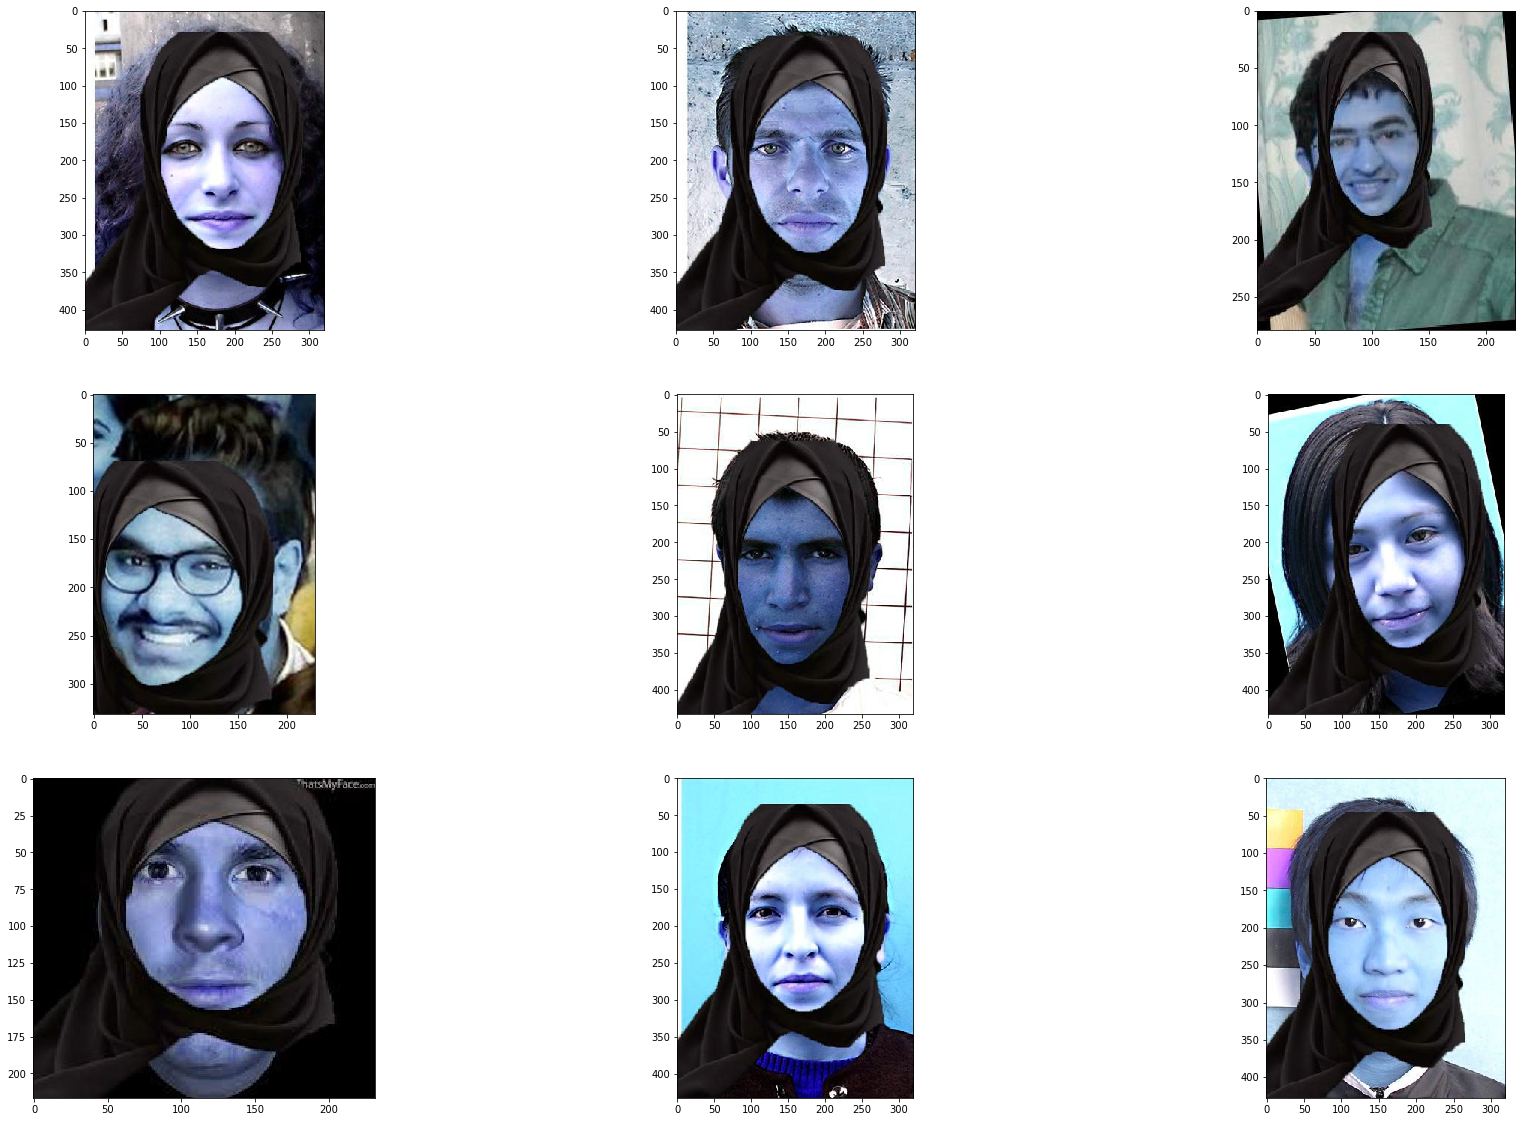

In [26]:
view(HIDPATH)

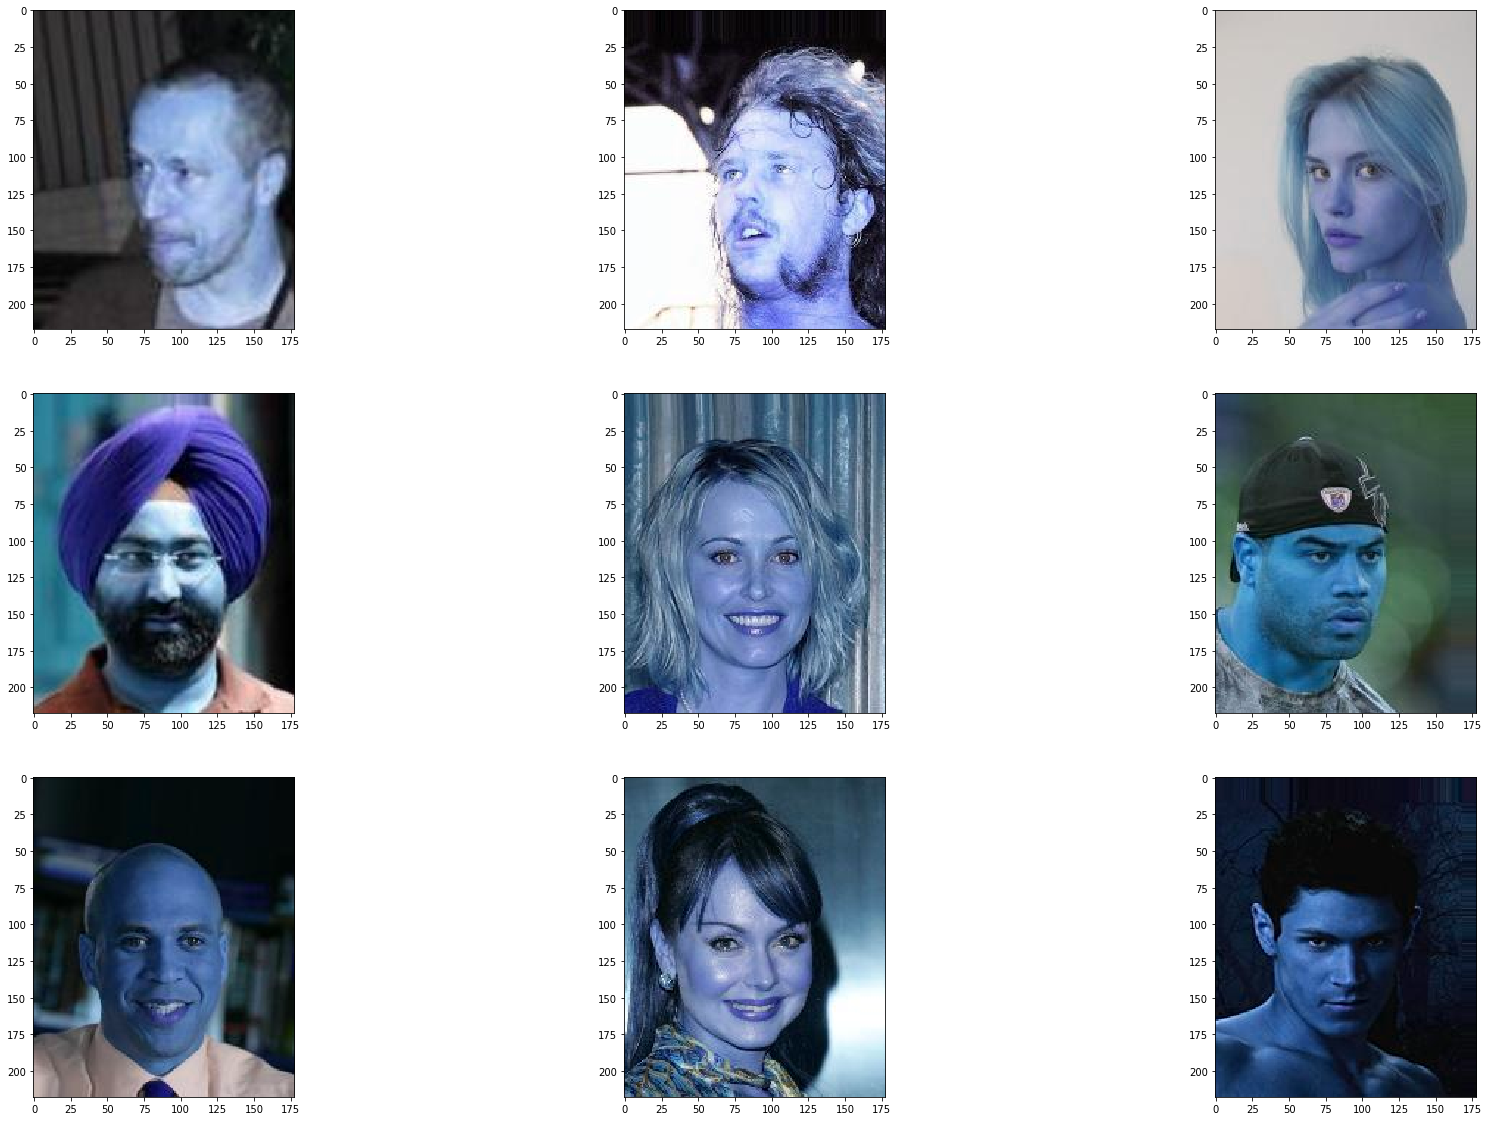

In [27]:
view(NOHIDPATH)

У нас есть <br>
В хиджабе: 571 <br>
Без хиджаба: 662 <br>
В целом, достаточно сбалансированные данные. Отделим немножко для теста

In [10]:
os.mkdir(TESTPATH)
os.mkdir(os.path.join(TESTPATH,'with_hid'))
os.mkdir(os.path.join(TESTPATH,'without_hid'))

FileExistsError: [Errno 17] File exists: '/Users/leonidts/Documents/rnd-42/5Test/1/Classifier/data/test/'

In [13]:
def getTest(pth1, pth2):
    dataSplit = int(np.ceil(len(os.listdir(pth1))*0.02))
    for img in os.listdir(pth1)[-dataSplit:]:
        shutil.move(os.path.join(pth1,img), os.path.join(pth2,img))
getTest(HIDPATH, '/Users/leonidts/Documents/rnd-42/5Test/1/Classifier/data/test/with_hid/')
getTest(NOHIDPATH, '/Users/leonidts/Documents/rnd-42/5Test/1/Classifier/data/test/without_hid/')

In [14]:
len(os.listdir(HIDPATH)),len(os.listdir(NOHIDPATH))

(635, 547)

In [15]:
len(os.listdir(os.path.join(TESTPATH,'with_hid'))),len(os.listdir(os.path.join(TESTPATH,'without_hid')))

(27, 24)

Готовим пайпланы входных данных

In [28]:
BATCH_SIZE = 32

In [29]:
trainGen = ImageDataGenerator(
    rescale= 1/255.,
    horizontal_flip=True,
    validation_split = 0.1
)

testGen = ImageDataGenerator(
    rescale= 1/255.,
)

In [30]:
train = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_hid','without_hid'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training'
)

validation = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_hid','without_hid'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='validation'
)

test = testGen.flow_from_directory(
    TESTPATH, 
    target_size=(224, 224), 
    classes=['with_hid','without_hid'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

Found 947 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


Используем "компактную" (https://habr.com/ru/post/352804/) архитектуру MobileNetV2

In [31]:
mob = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False

К ней прикрутим в последовательность еще 4 слоя.
Сначала делаем усреднение, затем будут традиционные функции активации relu и сигмоиду (подходящую именно в случае бинарной классификации), а между ними сдеалаем Dropout для избежания переобучения.

In [32]:
model = Sequential()
model.add(mob)
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


Воспользуемся бинарной кросс-эентропией, поскольку делим объекты на 2 класса.

In [33]:
model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['acc'])

In [34]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

И довольно быстро мы сошлись к оптимальным весам для нашей сети.

In [35]:
hist = model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    callbacks = [checkpoint]
)

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 0.2026 - acc: 0.9440
Epoch 00001: val_loss improved from inf to 0.02280, saving model to model.h5
30/30 [==============================] - 19s 627ms/step - loss: 0.2026 - acc: 0.9440 - val_loss: 0.0228 - val_acc: 0.9904
Epoch 2/10
30/30 [==============================] - ETA: 0s - loss: 0.0188 - acc: 0.9968
Epoch 00002: val_loss improved from 0.02280 to 0.01780, saving model to model.h5
30/30 [==============================] - 18s 601ms/step - loss: 0.0188 - acc: 0.9968 - val_loss: 0.0178 - val_acc: 0.9904
Epoch 3/10
30/30 [==============================] - ETA: 0s - loss: 0.0104 - acc: 0.9989
Epoch 00003: val_loss improved from 0.01780 to 0.01364, saving model to model.h5
30/30 [==============================] - 18s 614ms/step - loss: 0.0104 - acc: 0.9989 - val_loss: 0.0136 - val_acc: 0.9904
Epoch 4/10
30/30 [==============================] - ETA: 0s - loss: 0.0047 - acc: 1.0000
Epoch 00004: val_loss improved from 0.0

In [36]:
model.evaluate(test)

2/2 [==============================] - 0s 144ms/step - loss: 3.5351e-04 - acc: 1.0000


[0.0003535112482495606, 1.0]

In [37]:
m = model.to_json()

In [38]:
with open('model.json', 'w') as f:
    f.write(m)

In [39]:
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import cv2
    
with open('model.json', 'r') as f:
    loaded_model_json = f.read()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")
print("Loaded model from disk")

resMap = {
        0 : 'Hijab on',
        1 : 'No hijab'
    }

colorMap = {
        0 : (0,255,0),
        1 : (0,0,255)
    }

def prepImg(pth):
    return cv2.resize(pth,(224,224)).reshape(1,224,224,3)/255.0

classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
while True:
    ret,img = cap.read()
    faces = classifier.detectMultiScale(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),1.1,2)

    for face in faces:
        slicedImg = img[face[1]:face[1]+face[3],face[0]:face[0]+face[2]]
        pred = model.predict(prepImg(img))
        pred = np.argmax(pred)

        cv2.rectangle(img,(face[0],face[1]),(face[0]+face[2],face[1]+face[3]),colorMap[pred],2)
        cv2.putText(img, resMap[pred],(face[0],face[1]-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)        
        
                
    cv2.imshow('FaceMask Detection',img)
    if cv2.waitKey(1) & 0xff == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()


Loaded model from disk
